In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot = True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

In [119]:
#all models are here
# + building loss function

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
    
sess = tf.InteractiveSession(config=config)

input_dim = 784
enc_dim = 49

#input layer
x = tf.placeholder(tf.float32, shape=[None, input_dim]) 

def flat_ae(x):
    
   
    # hidden layer
    W_enc = tf.Variable(tf.random_normal([input_dim, 
                            enc_dim], mean=0.0, stddev=0.05) )
    b_enc = tf.Variable(tf.zeros([enc_dim]) )
    h = tf.nn.relu(tf.matmul(x, W_enc) + b_enc)  
    
    
    
    #output layer
    W_dec = tf.Variable(tf.random_normal([enc_dim,
                            input_dim], mean=0.0, stddev=0.05))
    b_dec = tf.Variable(tf.zeros([input_dim]))
    y = tf.nn.sigmoid(tf.matmul(h, W_dec) + b_dec)
    
    
    return y

def deep_sparse_ae(x):
    beta = 0.001
    
     #1st hidden layer
    W_1 = tf.Variable(tf.random_normal([input_dim, 256], mean=0.0, stddev=0.05))
    b_1 = tf.Variable(tf.zeros(256))
    h_1 = tf.matmul(x, W_1) + b_1
    
    # hidden layer
    W_enc = tf.Variable(tf.random_normal([256, 
                            enc_dim], mean=0.0, stddev=0.05) )
    b_enc = tf.Variable(tf.zeros([enc_dim]) )
    h = tf.nn.relu(tf.matmul(h_1, W_enc) + b_enc)  
    
    #3rd hidden layer
    W_3 = tf.Variable(tf.random_normal([enc_dim, 256], mean=0.0, stddev=0.05))
    b_3 = tf.Variable(tf.zeros(256))
    h_3 = tf.matmul(h, W_3) + b_3
    
    
    #output layer
    W_dec = tf.Variable(tf.random_normal([256,
                            input_dim], mean=0.0, stddev=0.05))
    b_dec = tf.Variable(tf.zeros([input_dim]))
    y = tf.nn.sigmoid(tf.matmul(h_3, W_dec) + b_dec)
    
    
    L2_penalty = beta * (tf.nn.l2_loss(W_enc) + tf.nn.l2_loss(b_enc))
    
    return L2_penalty, y

def denoising_ae(x):
    def gaussian_noise_layer(input_layer):
        noise = tf.random_normal(shape=tf.shape(input_layer), mean=0.3, stddev=0.3, dtype=tf.float32) 
        return input_layer + noise
    input_layer = gaussian_noise_layer(x)
    
    return input_layer, conv_ae2(input_layer)
    

def conv_ae2(x):
    # this is modified code from https://github.com/astorfi/TensorFlow-World/blob/master/codes/3-neural_networks/undercomplete-autoencoder/code/autoencoder.py
    # no maxpooling/upsampling, only convolution/deconvolution
     # encoder
    # 28 x 28 x 1   ->  14 x 14 x 32
    # 14 x 14 x 32  ->  7 x 7 x 16
    # 7 x 7 x 16    ->  7 x 7 x 1
    conv = tf.layers.conv2d
    conv_t = tf.layers.conv2d_transpose
    
    inputs = tf.reshape(x, [-1, 28, 28, 1])
    print("input: ", inputs.shape)
    
    net = conv(inputs, 32, [5, 5], strides=2,
                      padding='SAME', activation=tf.nn.relu)
    print("conv_1: ", net.shape)

    net = conv(net, 16, [5, 5], strides=2, 
                      padding='SAME', activation=tf.nn.relu)
    print("conv_2: ", net.shape)
    
    net = conv(net, 1, [7, 7],  
                      padding='SAME', activation=tf.nn.sigmoid)
    print("hidden: ", net.shape)
    # decoder
    # 7 x 7 x 1    ->  7 x 7 x 16
    # 7 x 7 x 16   ->  14 x 14 x 32
    # 14 x 14 x 32  ->  28 x 28 x 1
    net = conv_t(net, 16, [5, 5], strides=2,
                     padding='SAME', activation=tf.nn.relu)
    print("deconv_1: ", net.shape)
    
    net = conv_t(net, 32, [5, 5], strides=2,
                     padding='SAME', activation=tf.nn.relu)
    print("deconv_2: ", net.shape)
    
    net = conv_t(net, 1, [5, 5],
            padding='SAME', activation=tf.nn.sigmoid)
    print("out: ", net.shape)
    
    net = tf.reshape(net, [-1, input_dim])

    return net



def deep_ae(x):
    #hidden layer 1
    W1_enc = tf.Variable(tf.random_normal([input_dim,
                    enc_dim*3], mean=0.0, stddev=0.05) )
    b1_enc = tf.Variable(tf.zeros([enc_dim*3]) )
    h1_enc = tf.nn.relu(tf.matmul(x, W1_enc) + b1_enc)  

    #hidden layer 2
    W2_enc = tf.Variable(tf.random_normal([enc_dim*3,
                    enc_dim*2], mean=0.0, stddev=0.05) )
    b2_enc = tf.Variable(tf.zeros([enc_dim*2]) )
    h2_enc = tf.nn.relu(tf.matmul(h1_enc, W2_enc) + b2_enc) 
    
    #hidden in the middle
    W3_enc = tf.Variable(tf.random_normal([enc_dim*2, enc_dim],
                            mean=0.0, stddev=0.05) )
    b3_enc = tf.Variable(tf.zeros([enc_dim]) )
    h3_enc = tf.nn.sigmoid(tf.matmul(h2_enc, W3_enc) + b3_enc) #linear activation
    
    #hidden layer 4
    W4_dec = tf.Variable(tf.random_normal([enc_dim, enc_dim*2],
                                         mean=0.0, stddev=0.05))
    b4_dec = tf.Variable(tf.zeros([enc_dim*2]))
    h4_dec = tf.nn.relu(tf.matmul(h3_enc, W4_dec) + b4_dec)
    
    #hidden layer 5
    W5_dec = tf.Variable(tf.random_normal([enc_dim*2, enc_dim*3],
                                mean=0.0, stddev=0.05))
    b5_dec = tf.Variable(tf.zeros([enc_dim*3]))
    h5_dec = tf.nn.relu(tf.matmul(h4_dec, W5_dec) + b5_dec)
    
    #output layer
    W6_dec = tf.Variable(tf.random_normal([enc_dim*3, input_dim],
                                    mean=0.0, stddev=0.05))
    b6_dec = tf.Variable(tf.zeros([input_dim]))
    y = tf.nn.sigmoid(tf.matmul(h5_dec, W6_dec) + b6_dec)
    return y


#in_noised, y = denoising_ae(x)
l2, y = flat_sparse_ae(x)
y_ = tf.placeholder(tf.float32, shape=[None, input_dim])

loss = tf.reduce_mean(tf.pow(y - y_, 2) + l2)
#loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_,
 #                                             logits=y))
train_step = tf.train.AdamOptimizer().minimize(loss)
sess.run(tf.global_variables_initializer())

In [120]:
num_epochs = 20
num_images = 55000
batch_size = 256
val_batch_size = 256
steps_in_epoch = num_images / batch_size
for i in range(int(num_epochs * steps_in_epoch)):
    batch = mnist.train.next_batch(batch_size)
    train_step.run(feed_dict={x: batch[0], y_: batch[0]})
    if i % 100 == 0:
        print('Training Step:' + str(i) + 
           #   '  train loss =  ' + str(sess.run(loss, feed_dict={x: mnist.train.images, y_: mnist.train.images})) + 
              '  test loss = ' + str(sess.run(loss, {x: mnist.test.next_batch(val_batch_size)[0],
                                                     y_: mnist.test.next_batch(val_batch_size)[0]})))

Training Step:0  test loss = 0.243973
Training Step:100  test loss = 0.0891823
Training Step:200  test loss = 0.100585
Training Step:300  test loss = 0.105262
Training Step:400  test loss = 0.106449
Training Step:500  test loss = 0.106259
Training Step:600  test loss = 0.108656
Training Step:700  test loss = 0.112345
Training Step:800  test loss = 0.118865
Training Step:900  test loss = 0.118772
Training Step:1000  test loss = 0.113143
Training Step:1100  test loss = 0.116614
Training Step:1200  test loss = 0.118822
Training Step:1300  test loss = 0.122932
Training Step:1400  test loss = 0.120822
Training Step:1500  test loss = 0.117151
Training Step:1600  test loss = 0.123917
Training Step:1700  test loss = 0.121786
Training Step:1800  test loss = 0.119715
Training Step:1900  test loss = 0.120491
Training Step:2000  test loss = 0.124067
Training Step:2100  test loss = 0.125318
Training Step:2200  test loss = 0.123594
Training Step:2300  test loss = 0.124745
Training Step:2400  test lo

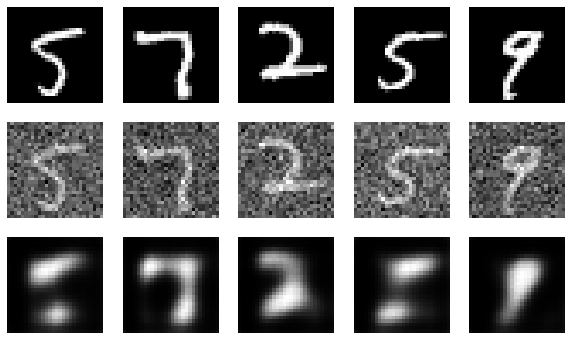

In [87]:
#show results for denoising AE
n = 5
imgs = mnist.test.images[:n]
noised_imgs = in_noised.eval(feed_dict={x:imgs})
decoded_imgs = y.eval(feed_dict={in_noised:noised_imgs})

im_to_plot = np.reshape(imgs, (n, 28, 28, 1))
im_out_to_plot_noised = np.reshape(noised_imgs, (n, 28, 28, 1))
im_out_to_plot_decoded = np.reshape(decoded_imgs, (n, 28, 28, 1))

plot_digits(im_to_plot, im_out_to_plot_noised, im_out_to_plot_decoded)

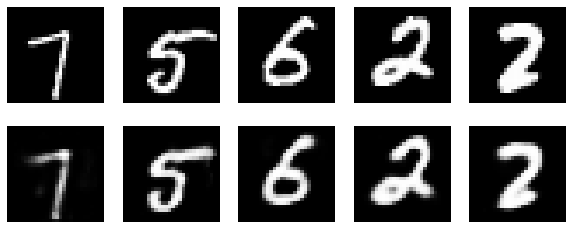

In [122]:
#show results for simple AEs
n = 5
imgs = mnist.test.images[:n]
enc_dec_imgs = y.eval(feed_dict={x:imgs})

im_to_plot = np.reshape(imgs, (n, 28, 28, 1))
im_out_to_plot = np.reshape(enc_dec_imgs, (n, 28, 28, 1))
plot_digits(im_to_plot, im_out_to_plot)

In [ ]:
enc_dec_images.shape